<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/07_milestone_project_1_food_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. <a id='toc1_'></a>[Milestone Project 1: Food Vision Big](#toc0_)

See the annotated version (plenty of text and explanations for each part) of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

And see the full course materials (including exercises and extra-curriculum) on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

**Table of contents**<a id='toc0_'></a>    
- 1. [Milestone Project 1: Food Vision Big](#toc1_)    
  - 1.1. [Check GPU](#toc1_1_)    
  - 1.2. [Get helper functions](#toc1_2_)    
  - 1.3. [Use TensorFlow Datasets to Download Data](#toc1_3_)    
  - 1.4. [Exploring the Food101 data from TensorFlow Datasets](#toc1_4_)    
    - 1.4.1. [Plot an image from TensorFlow Datasets](#toc1_4_1_)    
  - 1.5. [Create preprocessing functions for our data](#toc1_5_)    
  - 1.6. [Batch & prepare datasets](#toc1_6_)    
  - 1.7. [Create modelling callbacks](#toc1_7_)    
  - 1.8. [Setup mixed precision training](#toc1_8_)    
  - 1.9. [Build feature extraction model](#toc1_9_)    
  - 1.10. [Checking layer dtype policies (are we using mixed precision?)](#toc1_10_)    
  - 1.11. [Fit the feature extraction model](#toc1_11_)    
  - 1.12. [Off to you...](#toc1_12_)    
- 2. [Load and evaluate checkpoint weights](#toc2_)    
  - 2.1. [Save the whole model to file](#toc2_1_)    
  - 2.2. [TODO: Preparing our model's layers for fine-tuning](#toc2_2_)    
  - 2.3. [TODO: View training results on TensorBoard](#toc2_3_)    
  - 2.4. [TODO: Evaluate your trained model](#toc2_4_)    
  - 2.5. [🛠 Exercises](#toc2_5_)    
  - 2.6. [📖 Extra-curriculum](#toc2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[Check GPU](#toc0_)

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible) 
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

📖 **Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision 


In [505]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-16 14:40:32.778535


In [506]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA RTX 6000 Ada Generation (UUID: GPU-05232e34-60fb-266d-7837-9f94f83f5f32)
GPU 1: NVIDIA RTX A6000 (UUID: GPU-58afc507-4ca9-37c9-8df3-7349a4291eea)


```
/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA RTX 6000 Ada Generation (UUID: GPU-05232e34-60fb-266d-7837-9f94f83f5f32)
GPU 1: NVIDIA RTX A6000 (UUID: GPU-58afc507-4ca9-37c9-8df3-7349a4291eea)
```

In [507]:
# Check your software and os version
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

# tensorflow
import tensorflow as tf
print("TensorFlow version is",tf.__version__)

print("Are we using a GPU?",len(tf.config.experimental.list_physical_devices('GPU'))>0)

# Pytorch
#import torch
#print("Pytorch version is",torch.__version__)

#print("Are we using a GPU?",torch.cuda.is_available())

posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.15.0-73-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True


```
posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.15.0-73-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True
```

## 1.2. <a id='toc1_2_'></a>[Get helper functions](#toc0_)

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [508]:
# ==================Download helper functions script==================

# =====for linux command=====
import os
PATH = 'https://github.com/chioujryu/Deep-Learning-API/raw/main/deep_learning_helper_functions_tensorflow.py'
BASENAME = os.path.basename(PATH)
if os.path.exists("deep_learning_helper_functions_tensorflow.py") != True:
    !wget https://github.com/chioujryu/Deep-Learning-API/raw/main/deep_learning_helper_functions_tensorflow.py
    print("Download Success")

# =====for windows command=====
# import wget
# import os
# PATH = 'https://github.com/chioujryu/Deep-Learning-API/raw/main/deep_learning_helper_functions_tensorflow.py'
# BASENAME = os.path.basename(PATH)
# if os.path.exists(BASENAME) != True:
#     wget.download(PATH)
#     print("Download Success")

In [509]:
# Import series of helper functions for the notebook
from deep_learning_helper_functions_tensorflow import create_tensorboard_callback, plot_loss_curves, compare_historys

## 1.3. <a id='toc1_3_'></a>[Use TensorFlow Datasets to Download Data](#toc0_)

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [510]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [511]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [512]:
# 有356個資料集
len(datasets_list)

1143

🛠 **Exercise:** Running the following cell can take a while using Google Colab (about 5-6 minutes). While your data is downloading, have a read through the TensorFlow Datasets documentation: https://www.tensorflow.org/datasets/overview

🔑 **Note:** Some of the datasets contained within TensorFlow datasets are over 100GB+, meaning if you run the cell below (outside of Google Colab), you might be downloading 100GB+ to your computer or the computer that you're using. Beware as this could take a large amount of bandwidth.

In [513]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits 
                                             shuffle_files=False,   # 這邊最好要用False，在Evaluate或是predict的時候比較不會出錯
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True,
                                             #batch_size=32,
                                             )

## 1.4. <a id='toc1_4_'></a>[Exploring the Food101 data from TensorFlow Datasets](#toc0_)

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [514]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [515]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [516]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [517]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [518]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [519]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [520]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### 1.4.1. <a id='toc1_4_1_'></a>[Plot an image from TensorFlow Datasets](#toc0_)

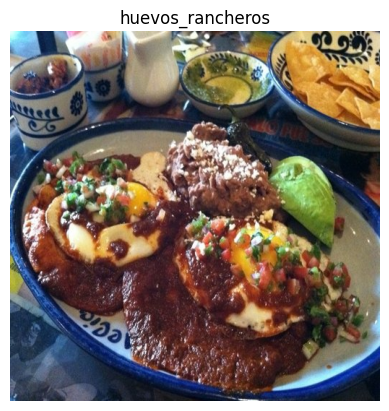

In [521]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## 1.5. <a id='toc1_5_'></a>[Create preprocessing functions for our data](#toc0_)

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [522]:
# Our data comes in the tuple structure: (image, label)

In [523]:
# Make a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image,[img_shape,img_shape])# reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image,tf.float32), label  # return (float32_image, label) tuple

In [524]:
# Preprocess a single sample image and check the outputs
preprocessed_img  = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## 1.6. <a id='toc1_6_'></a>[Batch & prepare datasets](#toc0_)

We're now going to make our data input pipeline run really fast. 

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [525]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data  = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## 1.7. <a id='toc1_7_'></a>[Create modelling callbacks](#toc0_)

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [526]:
# Create tensorboard callback (import from helper_functions.py)
# Reference: https://github.com/chioujryu/Deep-Learning-API
from deep_learning_helper_functions_tensorflow import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = "ckeckpoint/101_food_classes_feature_extract/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                    monitor = 'val_loss',
                                    verbose = 0,   # don't print whether or not model is being saved
                                    save_best_only = True,
                                    save_weights_only = True,
                                    mode = 'auto',
                                    save_freq = 'epoch',
                                    options = None,
                                    initial_value_threshold = None,
                                   )

## 1.8. <a id='toc1_8_'></a>[Setup mixed precision training](#toc0_)

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [527]:
# Turn on mixed precision training
tf.keras.mixed_precision.set_global_policy("mixed_float16")     # set global data policy to mixed precision 

In [528]:
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## 1.9. <a id='toc1_9_'></a>[Build feature extraction model](#toc0_)

In [529]:
# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                                weights='imagenet',
                                                                input_tensor=None,
                                                                input_shape=None,
                                                                pooling=None,
                                                                classes=1000,
                                                                classifier_activation='softmax')
base_model.trainable = False

# Create functional model
inputs = tf.keras.Input(shape=input_shape, name="input_layer")

# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training = False) # makes sure layers which should be in inference mode only stay like that
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [530]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 dense_13 (Dense)            (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                          

## 1.10. <a id='toc1_10_'></a>[Checking layer dtype policies (are we using mixed precision?)](#toc0_)

In [531]:
model.layers

In [532]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, "|", layer.trainable, "|", layer.dtype, "|", layer.dtype_policy)

input_layer | True | float32 | <Policy "float32">
efficientnetb0 | False | float32 | <Policy "mixed_float16">
global_average_pooling_2D_layer | True | float32 | <Policy "mixed_float16">
dense_13 | True | float32 | <Policy "mixed_float16">
softmax_float32 | True | float32 | <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [533]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # check the layers of the base model (layer at index 1 of `model`)

input_14 False float32 <Policy "float32">
rescaling_13 False float32 <Policy "mixed_float16">
normalization_13 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn Fa

In [534]:
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## 1.11. <a id='toc1_11_'></a>[Fit the feature extraction model](#toc0_)

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen) 
2. Fine-tune some of the frozen layers

In [535]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                            epochs = 10, 
                            steps_per_epoch = (len(train_data)),
                            validation_data=test_data,
                            verbose = 2,
                            validation_steps=int(0.15 * len(test_data)),
                            callbacks=[create_tensorboard_callback(dir_name="training_logs", 
                                                                    experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230616-144037
Epoch 1/10


2368/2368 - 49s - loss: 1.8243 - accuracy: 0.5570 - val_loss: 1.2301 - val_accuracy: 0.6748 - 49s/epoch - 21ms/step
Epoch 2/10
2368/2368 - 47s - loss: 1.2953 - accuracy: 0.6664 - val_loss: 1.1247 - val_accuracy: 0.6976 - 47s/epoch - 20ms/step
Epoch 3/10
2368/2368 - 46s - loss: 1.1445 - accuracy: 0.7015 - val_loss: 1.0872 - val_accuracy: 0.7042 - 46s/epoch - 19ms/step
Epoch 4/10
2368/2368 - 46s - loss: 1.0467 - accuracy: 0.7266 - val_loss: 1.0716 - val_accuracy: 0.7121 - 46s/epoch - 19ms/step
Epoch 5/10
2368/2368 - 46s - loss: 0.9745 - accuracy: 0.7445 - val_loss: 1.0591 - val_accuracy: 0.7132 - 46s/epoch - 20ms/step
Epoch 6/10
2368/2368 - 46s - loss: 0.9168 - accuracy: 0.7584 - val_loss: 1.0713 - val_accuracy: 0.7079 - 46s/epoch - 19ms/step
Epoch 7/10
2368/2368 - 46s - loss: 0.8681 - accuracy: 0.7725 - val_loss: 1.0739 - val_accuracy: 0.7100 - 46s/epoch - 20ms/step
Epoch 8/10
2368/2368 - 47s - loss: 0.8281 - accuracy: 0.7823 - val_loss: 1.0751 - val_accuracy: 0.7113 - 47s/epoch - 20ms/

In [536]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 9s 12ms/step - loss: 1.0972 - accuracy: 0.7069


[1.0972206592559814, 0.7069306969642639]

## 1.12. <a id='toc1_12_'></a>[Off to you...](#toc0_)

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the TEMPLATE notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck, you can refer to the example version (non-template): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

# 2. <a id='toc2_'></a>[Load and evaluate checkpoint weights](#toc0_)

We can load in and evaluate our model's checkpoints by:

1. Recreating a new instance of our model called `created_model` by turning our original model creation code into a function called `create_model()`.
2. Compiling our `created_model` with the same loss, optimizer and metrics as the original model (every time you create a new model, you must compile it).
3. Calling the `load_weights()` method on our `created_model` and passing it the path to where our checkpointed weights are stored.
4. Calling `evaluate()` on `created_model` with loaded weights and saving the results.
5. Comparing the `created_model` results to our previous `model` results (these should be the exact same, if not very close).

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

> **Note:** This section originally used the `tf.keras.clone_model` [method](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model), however, due to several potential errors with that method, it changed to create a new model (rather than cloning) via a `create_model`() function. See the [discussion on the course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550) for more.

In [537]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model 
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class 
  # Separate activation of output layer so we can output float32 activations
  outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  model = tf.keras.Model(inputs, outputs)
  
  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data, verbose=2)

790/790 - 9s - loss: 1.0674 - accuracy: 0.7127 - 9s/epoch - 12ms/step


### Compare the model with loaded weight and feature extraction model
Our `created_model` with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).

In [538]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
# import numpy as np
# assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), \
#                                     "Loaded weights results are not close to original model."

### Cloning the model preserves `dtype_policy`'s of layers
Cloning the model preserves `dtype_policy`'s of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning our `created_model`, we could and it would still use the mixed precision dtype policy.

In [539]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_15 False float32 <Policy "float32">
rescaling_14 False float32 <Policy "mixed_float16">
normalization_14 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn Fa

## 2.1. <a id='toc2_1_'></a>[Save the whole model to file](#toc0_)

In [540]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [541]:
!ls saved_model/my_model

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
assets	keras_metadata.pb  saved_model.pb  variables


In [542]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model('saved_model/my_model')

In [543]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers[1].layers:
    print(layer.name, "|", layer.trainable, "|", layer.dtype, "|", layer.dtype_policy)

input_14 | True | float32 | <Policy "float32">
rescaling_13 | False | float32 | <Policy "mixed_float16">
normalization_13 | False | float32 | <Policy "mixed_float16">
stem_conv_pad | False | float32 | <Policy "mixed_float16">
stem_conv | False | float32 | <Policy "mixed_float16">
stem_bn | False | float32 | <Policy "mixed_float16">
stem_activation | False | float32 | <Policy "mixed_float16">
block1a_dwconv | False | float32 | <Policy "mixed_float16">
block1a_bn | False | float32 | <Policy "mixed_float16">
block1a_activation | False | float32 | <Policy "mixed_float16">
block1a_se_squeeze | False | float32 | <Policy "mixed_float16">
block1a_se_reshape | False | float32 | <Policy "mixed_float16">
block1a_se_reduce | False | float32 | <Policy "mixed_float16">
block1a_se_expand | False | float32 | <Policy "mixed_float16">
block1a_se_excite | False | float32 | <Policy "mixed_float16">
block1a_project_conv | False | float32 | <Policy "mixed_float16">
block1a_project_bn | False | float32 | <Po

In [544]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_model = loaded_model.evaluate(test_data, verbose=2)

790/790 - 10s - loss: 1.0972 - accuracy: 0.7069 - 10s/epoch - 12ms/step


In [545]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
assert np.isclose(results_feature_extract_model ,results_loaded_model).all(), "Loaded weights results are not close to original model."

## 2.2. <a id='toc2_2_'></a>[TODO: Preparing our model's layers for fine-tuning](#toc0_)

**Next:** Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [546]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-06-16 14:49:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:2::2010, 2404:6800:4012:3::2010, 2404:6800:4012:4::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:2::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 16976857 (16M) [application/zip]
儲存到：`07_efficientnetb0_feature_extract_model_mixed_precision.zip'

07_efficientnetb0_f 100%[===================>]  16.19M  15.4MB/s    於 1.0s     

2023-06-16 14:49:13 (15.4 MB/s) - 已儲存 `07_efficientnetb0_feature_extract_model_mixed_precision.zip' [16976857/16976857]



In [547]:
# Unzip the SavedModel downloaded from Google Stroage
downloaded_gs_model_path = "saved_model"
!mkdir $downloaded_gs_model_path # create new dir to store downloaded feature extraction model

folder_name = "07_efficientnetb0_feature_extract_model_mixed_precision"

import os
if not os.path.exists(os.path.join(downloaded_gs_model_path, folder_name)):
    !unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d $downloaded_gs_model_path

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: 無法建立 「saved_model」 目錄: 檔案已存在


In [548]:
# Remove zip file
!rm 07_efficientnetb0_feature_extract_model_mixed_precision.zip

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [550]:
# Load and evaluate downloaded GS model 
efficientnetb0_feature_extract_model_mixed_precision_path = \
"saved_model/07_efficientnetb0_feature_extract_model_mixed_precision"

efficientnetb0_mixed_precision_model = tf.keras.models.load_model(efficientnetb0_feature_extract_model_mixed_precision_path)

# clear output
from IPython.display import clear_output 
clear_output()

In [551]:
# Get a summary of the downloaded model
efficientnetb0_mixed_precision_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [552]:
# How does the loaded model perform? (evaluate it on the test dataset)
efficientnetb0_mixed_precision_model.evaluate(test_data)

790/790 [==============================] - 10s 12ms/step - loss: 1.0881 - accuracy: 0.7065


[1.08810555934906, 0.7065346240997314]

In [553]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
# for i in range(len(efficientnetb0_mixed_precision_model.layers)):
#     efficientnetb0_mixed_precision_model.layers[i].trainable

for layer in efficientnetb0_mixed_precision_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, "|", layer.trainable, "|", layer.dtype, "|", layer.dtype_policy)

input_layer | True | float32 | <Policy "float32">
efficientnetb0 | True | float32 | <Policy "mixed_float16">
pooling_layer | True | float32 | <Policy "mixed_float16">
dense | True | float32 | <Policy "mixed_float16">
softmax_float32 | True | float32 | <Policy "float32">


In [554]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in efficientnetb0_mixed_precision_model.layers:
    print(layer.name, "|", layer.trainable, "|", layer.dtype, "|", layer.dtype_policy)

input_layer | True | float32 | <Policy "float32">
efficientnetb0 | True | float32 | <Policy "mixed_float16">
pooling_layer | True | float32 | <Policy "mixed_float16">
dense | True | float32 | <Policy "mixed_float16">
softmax_float32 | True | float32 | <Policy "float32">


In [555]:
# Check the layers in the base model and see what dtype policy they're using
for layer in efficientnetb0_mixed_precision_model.layers[1].layers[:20]:
    print(layer.name, "|", layer.trainable, "|", layer.dtype, "|", layer.dtype_policy)

input_1 | True | float32 | <Policy "float32">
rescaling | True | float32 | <Policy "mixed_float16">
normalization | True | float32 | <Policy "float32">
stem_conv_pad | True | float32 | <Policy "mixed_float16">
stem_conv | True | float32 | <Policy "mixed_float16">
stem_bn | True | float32 | <Policy "mixed_float16">
stem_activation | True | float32 | <Policy "mixed_float16">
block1a_dwconv | True | float32 | <Policy "mixed_float16">
block1a_bn | True | float32 | <Policy "mixed_float16">
block1a_activation | True | float32 | <Policy "mixed_float16">
block1a_se_squeeze | True | float32 | <Policy "mixed_float16">
block1a_se_reshape | True | float32 | <Policy "mixed_float16">
block1a_se_reduce | True | float32 | <Policy "mixed_float16">
block1a_se_expand | True | float32 | <Policy "mixed_float16">
block1a_se_excite | True | float32 | <Policy "mixed_float16">
block1a_project_conv | True | float32 | <Policy "mixed_float16">
block1a_project_bn | True | float32 | <Policy "mixed_float16">
block2a

In [556]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE
EarlyStopping = tf.keras.callbacks.EarlyStopping(   monitor='val_loss',
                                                    min_delta=0,
                                                    patience=3,
                                                    verbose=0,
                                                    mode='auto',
                                                    baseline=None,
                                                    restore_best_weights=True,
                                                )

                                                
# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE
# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = "ckeckpoint/efficientnetb0_mixed_precision_model/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                    monitor = 'val_loss',
                                    verbose = 0,   # don't print whether or not model is being saved
                                    save_best_only = True,
                                    save_weights_only = True,
                                    mode = 'auto',
                                    save_freq = 'epoch',
                                    options = None,
                                    initial_value_threshold = None,
                                   )

In [557]:
# Creating learning rate reduction 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [558]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

/home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [559]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

# Fine-tune for 5 more epochs
fine_tune_epochs = 100 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_efficientnetb0_mixed_precision_model_fine_tune =  model.fit(train_data,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        verbose = 2,
                        #initial_epoch=history_all_classes_10_percent.epoch[-1],
                        callbacks=[model_checkpoint,
                                    EarlyStopping,
                                    reduce_lr,
                                    create_tensorboard_callback(dir_name="training_logs", 
                                        experiment_name="efficientnetb0_mixed_precision_model_fine_tune")])


Saving TensorBoard log files to: training_logs/efficientnetb0_mixed_precision_model_fine_tune/20230616-184036
Epoch 1/100


2368/2368 - 48s - loss: 0.6583 - accuracy: 0.8345 - val_loss: 1.0612 - val_accuracy: 0.7161 - lr: 1.0000e-04 - 48s/epoch - 20ms/step
Epoch 2/100
2368/2368 - 45s - loss: 0.6477 - accuracy: 0.8389 - val_loss: 1.0594 - val_accuracy: 0.7169 - lr: 1.0000e-04 - 45s/epoch - 19ms/step
Epoch 3/100
2368/2368 - 44s - loss: 0.6427 - accuracy: 0.8400 - val_loss: 1.0591 - val_accuracy: 0.7182 - lr: 1.0000e-04 - 44s/epoch - 19ms/step
Epoch 4/100
2368/2368 - 45s - loss: 0.6387 - accuracy: 0.8420 - val_loss: 1.0596 - val_accuracy: 0.7169 - lr: 1.0000e-04 - 45s/epoch - 19ms/step
Epoch 5/100

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 - 45s - loss: 0.6354 - accuracy: 0.8430 - val_loss: 1.0600 - val_accuracy: 0.7161 - lr: 1.0000e-04 - 45s/epoch - 19ms/step
Epoch 6/100
2368/2368 - 46s - loss: 0.6243 - accuracy: 0.8464 - val_loss: 1.0582 - val_accuracy: 0.7193 - lr: 2.0000e-05 - 46s/epoch - 19ms/step
Epoch 7/100
2368/2368 - 45s - loss: 0.6231 - accuracy: 0.8470 - 

> 🔑 **Note:** If you didn't use mixed precision or use techniques such as [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) in the *Batch & prepare datasets* section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

| | Prefetch and mixed precision | No prefetch and no mixed precision |
|-----|-----|-----|
| Time per epoch | ~280-300s | ~1127-1397s |

*Results from fine-tuning 🍔👁 Food Vision Big™ on Food101 dataset using an EfficienetNetB0 backbone using a Google Colab Tesla T4 GPU.*

```
Saving TensorBoard log files to: training_logs/efficientB0_101_classes_all_data_fine_tuning/20200928-013008
Epoch 1/100
2368/2368 [==============================] - 1397s 590ms/step - loss: 1.2068 - accuracy: 0.6820 - val_loss: 1.1623 - val_accuracy: 0.6894
Epoch 2/100
2368/2368 [==============================] - 1193s 504ms/step - loss: 0.9459 - accuracy: 0.7444 - val_loss: 1.1549 - val_accuracy: 0.6872
Epoch 3/100
2368/2368 [==============================] - 1143s 482ms/step - loss: 0.7848 - accuracy: 0.7838 - val_loss: 1.0402 - val_accuracy: 0.7142
Epoch 4/100
2368/2368 [==============================] - 1127s 476ms/step - loss: 0.6599 - accuracy: 0.8149 - val_loss: 0.9599 - val_accuracy: 0.7373
```
*Example fine-tuning time for non-prefetched data as well as non-mixed precision training (~2.5-3x longer per epoch).*

Let's make sure we save our model before we start evaluating it.

From the above, does it look like our model is overfitting or underfitting? 

Remember, if the training loss is significantly lower than the validation loss, it's a hint that the model has overfit the training data and not learned generalizable patterns to unseen data.

But it does look like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the [DeepFood paper's](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.

In [560]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
efficientnetb0_mixed_precision_model_fine_tune_path = "saved_model/efficientnetb0_mixed_precision_model_fine_tune"
model.save(efficientnetb0_mixed_precision_model_fine_tune_path)

INFO:tensorflow:Assets written to: saved_model/efficientnetb0_mixed_precision_model_fine_tune/assets


INFO:tensorflow:Assets written to: saved_model/efficientnetb0_mixed_precision_model_fine_tune/assets


In [561]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
model.evaluate(test_data)

790/790 [==============================] - 9s 12ms/step - loss: 1.0642 - accuracy: 0.7143


[1.0641742944717407, 0.7142574191093445]

## 2.3. <a id='toc2_3_'></a>[TODO: View training results on TensorBoard](#toc0_)

**To do:** Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [562]:
# YOUR_CODE_HERE
# 請用Terminal 輸入，如果無法執行，代表妳的tensorboard版本不夠高
# 注意！！！！　請重新建立一個新的 TensorFlow 環境，並且用 TensorBoard 的最高版本，再用Terminal執行
!tensorboard dev upload --logdir ./training_logs \
  --name "Milestone project 1 food vision video" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2023-06-16 18:48:35.892109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:35.892197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:35.905391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:35.905494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so re

tensorboard                  2.8.0
tensorboard-data-server      0.6.1
tensorboard-plugin-wit       1.8.1

Viewing at our [model's training curves on TensorBoard.dev](https://tensorboard.dev/experiment/21Nv7P4eTV62O7VokENEhw/#scalars), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/21Nv7P4eTV62O7VokENEhw/#scalars

To fix this, in future experiments, we might try things like:
* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.

In [563]:
# View past TensorBoard experiments
!tensorboard dev list

/bin/bash: /home/cosmo/anaconda3/envs/TensorFlow_2.8.3__Python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2023-06-16 18:48:38.392201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:38.392290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:38.405547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:48:38.405654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so re

In [564]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
# !tensorboard dev delete --experiment_id 3ikK6k3ATp27ZJJNdNblew

## 2.4. <a id='toc2_4_'></a>[TODO: Evaluate your trained model](#toc0_)

Some ideas you might want to go through:
1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's *most wrong* predictions (those with the highest prediction probability but the wrong prediction).

See the evaluation section at the end of [Transfer Learning Part 3: Scaling Up for more](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb).

In [565]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose = 1) # set verbosity to see how long it will take 
pred_probs   # 有161936個預測

790/790 [==============================] - 9s 10ms/step


array([[1.6755699e-03, 3.1969266e-06, 9.3765550e-07, ..., 8.2462124e-04,
        2.1054299e-04, 3.8623024e-02],
       [3.1984491e-05, 4.0743221e-06, 7.3356372e-05, ..., 2.3263645e-05,
        5.3624291e-04, 2.6933645e-05],
       [6.7608744e-06, 9.6862786e-06, 6.5098111e-06, ..., 3.9545631e-07,
        1.2227427e-05, 2.1881867e-07],
       ...,
       [9.8509900e-02, 1.0641494e-04, 6.0615304e-07, ..., 6.6853405e-05,
        3.0433445e-04, 5.3272009e-02],
       [7.8332334e-08, 6.9310174e-10, 2.0374435e-08, ..., 5.3141952e-10,
        1.3946455e-09, 1.1886076e-07],
       [7.5829267e-03, 2.4797779e-05, 9.2780759e-04, ..., 3.1086944e-02,
        1.8687400e-03, 3.8114353e-04]], dtype=float32)

In [566]:
pred_probs.shape

(25250, 101)

In [576]:
y_pred = pred_probs.argmax(axis=1)
y_pred

array([29, 81, 91, ..., 76, 31, 22])

In [590]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy())
  #y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [578]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

In [579]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, y_pred)
sklearn_accuracy
     

0.7142574257425742

In [581]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, y_pred, ))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47       250
           1       0.75      0.69      0.72       250
           2       0.73      0.76      0.75       250
           3       0.73      0.75      0.74       250
           4       0.62      0.58      0.60       250
           5       0.59      0.61      0.60       250
           6       0.80      0.80      0.80       250
           7       0.84      0.87      0.86       250
           8       0.46      0.46      0.46       250
           9       0.71      0.62      0.66       250
          10       0.69      0.58      0.63       250
          11       0.75      0.76      0.75       250
          12       0.74      0.74      0.74       250
          13       0.70      0.73      0.71       250
          14       0.71      0.66      0.68       250
          15       0.55      0.53      0.54       250
          16       0.53      0.56      0.55       250
          17       0.73    

## 2.5. <a id='toc2_5_'></a>[🛠 Exercises](#toc0_)

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:
  * A confusion matrix between all of the model's predictions and true labels.
  * A graph showing the f1-scores of each class.
  * A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label. 
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

## 2.6. <a id='toc2_6_'></a>[📖 Extra-curriculum](#toc0_)

* Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to keep in mind when using mixed precision training?